# Coding Assignment - "Graph Learning"

## 1. Preparation

### 1.1 Libraries

In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

# We will use networx objects to store empircial graphs, local datasets and models
import networkx as nx 
from sklearn.neighbors import kneighbors_graph
from numpy import linalg as LA

### 1.2 Helper functions

In [2]:
# The function generates a scatter plot of nodes (=FMI stations) using 
# latitude and longitude as coordinates. 
def plotFMI(G_FMI):
    
    # Get the coordinates of the stations.
    coords = np.array([G_FMI.nodes[node]['coord'] for node in G_FMI.nodes])
    
    # Draw nodes
    for node in G_FMI.nodes:
        plt.scatter(coords[node,1], coords[node,0], color='black', s=4, zorder=5)  # zorder ensures nodes are on top of edges
        plt.text(coords[node,1]+0.1, coords[node,0]+0.2, str(node), fontsize=8, ha='center', va='center', color='black', fontweight='bold')
    # Draw edges
    for edge in G_FMI.edges:
        plt.plot([coords[edge[0],1],coords[edge[1],1]], [coords[edge[0],0],coords[edge[1],0]], linestyle='-', color='gray', alpha=0.5)

    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('FMI stations')
    plt.show()

# The function below extracts a feature and label from each row 
# of dataframe df. Each row is expected to hold a FMI weather 
# measurement with cols "Latitude", "Longitude", "temp", "Timestamp". 
# Returns numpy arrays X, y.
def ExtractFeatureMatrixLabelVector(data):
    nrfeatures = 7 
    nrdatapoints = len(data)
    
    # We build the feature matrix X (each of its rows hold the features of a data point) 
    # and the label vector y (whose entries hold the labels of data points).
    X = np.zeros((nrdatapoints, nrfeatures))
    y = np.zeros((nrdatapoints, 1))

    # Iterate over all rows in dataframe and create corresponding feature vector and label. 
    for ind in range(nrdatapoints):
        # Latitude of FMI station, normalized by 100. 
        lat = float(data['Latitude'].iloc[ind])/100
        # Longitude of FMI station, normalized by 100.
        lon = float(data['Longitude'].iloc[ind])/100
        # Temperature value of the data point.
        tmp = data['temp'].iloc[ind]
        # Read the date and time of the temperature measurement. 
        date_object = datetime.strptime(data['Timestamp'].iloc[ind], '%Y-%m-%d %H:%M:%S')
        # Extract year, month, day, hour, and minute. Normalize these values 
        # to ensure that the features are in range [0,1].
        year = float(date_object.year)/2025
        month = float(date_object.month)/13
        day = float(date_object.day)/32
        hour = float(date_object.hour)/25
        minute = float(date_object.minute)/61
        
        # Store the data point's features and a label.
        X[ind,:] = [lat, lon, year, month, day, hour, minute]
        y[ind,:] = tmp

    return X, y

## 2. Data

### 2.1 Dataset

In [3]:
# Import the weather measurements.
data = pd.read_csv('Assignment_MLBasicsData.csv')

# We consider each temperature measurement (=a row in dataframe) as a 
# separate data point.
# Get the numbers of data points and the unique stations.
num_stations = len(data.name.unique())
num_datapoints = len(data)

### 2.2 Features and labels

In [4]:
# We next build the feature matrix X (each of its rows hold the features of a data point) 
# and the label vector y (whose entries hold the labels of data points).
X, y = ExtractFeatureMatrixLabelVector(data)

print(f"The created feature matrix contains {np.shape(X)[0]} entries of {np.shape(X)[1]} features each.")
print(f"The created label vector contains {np.shape(y)[0]} measurements.")

The created feature matrix contains 19768 entries of 7 features each.
The created label vector contains 19768 measurements.


### 2.3 Empirical graph

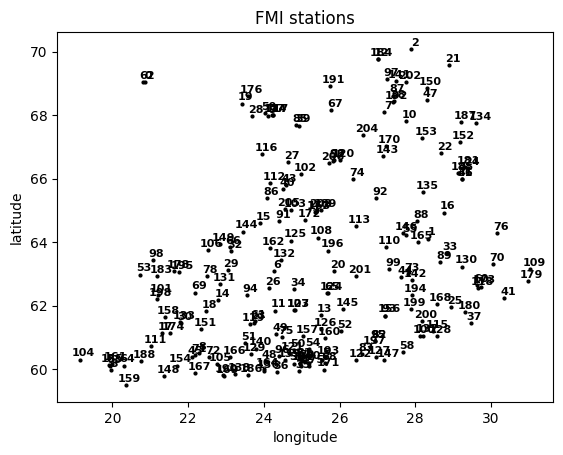

In [5]:
# Create a networkX graph
G_FMI = nx.Graph()

# Add a one node per station
G_FMI.add_nodes_from(range(0, num_stations))

for i, station in enumerate(data.name.unique()):
    # Extract data of a certain station
    station_data = data[data.name==station]
    
    # Extract features and labels
    X_node, y_node = ExtractFeatureMatrixLabelVector(station_data)

    localsamplesize = len(y_node)
    G_FMI.nodes[i]['samplesize'] = localsamplesize # The number of measurements of the i-th weather station
    G_FMI.nodes[i]['name'] = station # The name of the i-th weather station
    G_FMI.nodes[i]['coord'] = np.array([station_data.Latitude.unique()[0], station_data.Longitude.unique()[0]]) # The coordinates of the i-th weather station
    G_FMI.nodes[i]['X'] = X_node # The feature matrix for local dataset at node i
    G_FMI.nodes[i]['y'] = y_node  # The  label vector for local dataset at node i
    G_FMI.nodes[i]['z'] = None # The representation vector for local dataset at node i

# Visualize the empirical graph.
plotFMI(G_FMI)

## 3. The discrepancy measure

### 3.1 Helper function

In [8]:
# Inputs:
#    1. graph_FMI (class: networkx.classes.graph.Graph) - a graph to which the edges will be added.
#    2. node_degree (class: int) - the minimum number of neighbors (the minimum node degree).
# Outputs:
#    1. graph (class: networkx.classes.graph.Graph) - a graph with added edges.
def add_edges(graph_FMI, node_degree):
    graph = graph_FMI.copy()
    
    for node in graph.nodes:
            
        # TODO: Extract the representation vector of the node.
        z_node = graph.nodes[node]['z']
        # raise NotImplementedError
        
        # Create storages for discrepancies and the corresponding neighbors.
        d_mins = np.full(shape=node_degree, fill_value=1e10)
        edges = np.full(shape=(node_degree, 2), fill_value=(node, -1))
    
        for potential_neighbor in graph.nodes:
            if potential_neighbor != node:
                
                # TODO: Extract the representation vecotr of the potential neighbor.
                z_neighbor = graph.nodes[potential_neighbor]['z']
                # raise NotImplementedError
                
                # TODO: Calculate the discrepancy.
                d = np.linalg.norm(z_node - z_neighbor)
                # raise NotImplementedError

                # TODO: Find the max discrepancy so far.
                #       Also, find its index to access the 
                #       corresponding neighbor later.
                d_max_idx = np.argmax(d_mins)
                d_max = d_mins[d_max_idx]
                # raise NotImplementedError
                
                if d < d_max:
                    # TODO: Store the calculated discrepancy and
                    #       the corresponding neighbor.
                    d_mins[d_max_idx] = d
                    edges[d_max_idx] = [node, potential_neighbor]
                    # raise NotImplementedError

        # Add edges from the given pairs of connected nodes.
        graph.add_edges_from(edges) 

    return graph

### 3.2 Student task #1 - The average temperature 

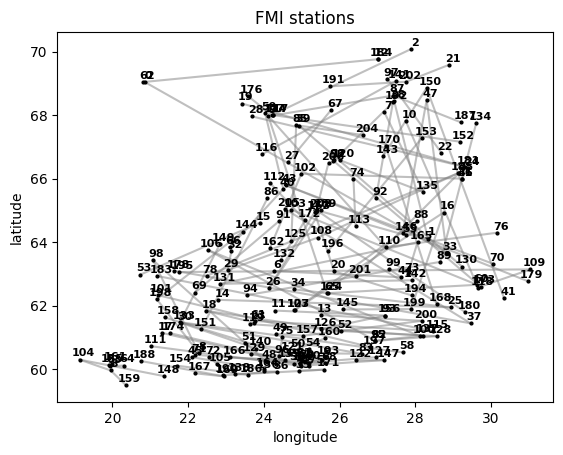

In [17]:
def add_edges_avg_temp(graph_FMI, n_neighbors): 
    # Copy the nodes to a new graph.
    graph = graph_FMI.copy()

    ####################TODO####################
    # TODO: 1. Create the representation vector for each node.
    #       2. Add the edges based on the representation vectors.
    # raise NotImplementedError

    for node in graph.nodes:
        temperatures = graph.nodes[node]['y']  # Assuming 'y' contains temperature data for the node
        avg_temp = np.mean(temperatures)
        graph.nodes[node]['z'] = np.array([avg_temp])  # Storing average temperature as representation vector

    # 2. Add the edges based on the representation vectors
    # Reusing the add_edges function provided or explained earlier
    graph = add_edges(graph, n_neighbors)
            
    return graph

# Visualize an example graph with 
# minimum node degree = 1. 
plotFMI(add_edges_avg_temp(G_FMI, 1))

### 3.3 Student task #2 - The difference in GMM parameters

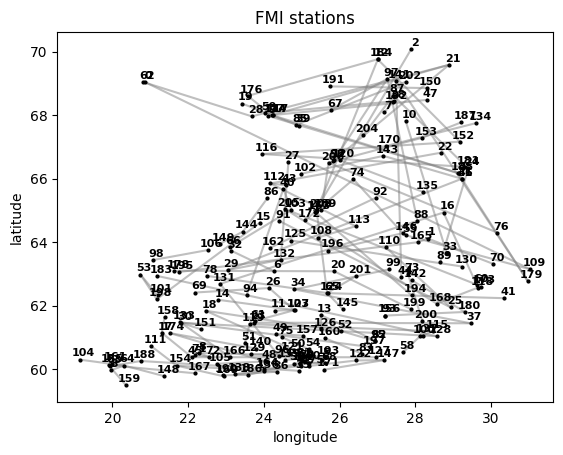

In [11]:
def add_edges_GMM_param(graph_FMI, GMM_seed, n_neighbors):
    # Copy the nodes to a new graph.
    graph = graph_FMI.copy()

    # Define the number components for the GMM. 
    n_components = 2

    ####################TODO####################
    # TODO: 1. Create the representation vector for each node (see "NOTE").
    #       2. Add the edges based on the representation vectors.
    # NOTE: Use the same GMM structure as in the "FL Flavors" assignment. 
    #       You can copy-paste your previous implementation.
    # raise NotImplementedError

    # 1. Fit a GMM for each node and store the parameters as the representation vector
    for node in graph.nodes:
        data = graph.nodes[node]['y'].reshape(-1, 1)  # Assuming 'y' contains temperature data for the node
        gmm = GaussianMixture(n_components=n_components, random_state=GMM_seed).fit(data)
        
        # Create a representation vector from the GMM parameters (concatenate means and covariances)
        means = gmm.means_.flatten()
        covariances = gmm.covariances_.flatten()
        representation_vector = np.concatenate([means, covariances])
        
        graph.nodes[node]['z'] = representation_vector

    # 2. Add the edges based on the representation vectors
    # Reusing the add_edges function provided or explained earlier
    graph = add_edges(graph, n_neighbors)

    return graph

# Visualize an example graph. 
plotFMI(add_edges_GMM_param(G_FMI, 4740, 1))

### 3.4 Student task #3 - The gradient of the average squared error loss

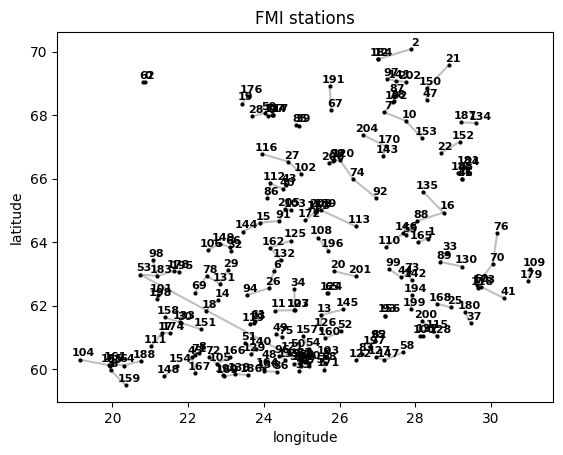

In [19]:
def add_edges_gradient_loss(graph_FMI, n_neighbors):
    graph = graph_FMI.copy()

    # Fit a linear regression model to the whole dataset to get global parameters
    global_X = np.concatenate([graph.nodes[node]['X'] for node in graph.nodes])
    global_y = np.concatenate([graph.nodes[node]['y'] for node in graph.nodes])
    linear_model = LinearRegression().fit(global_X, global_y)

    # Calculate the gradient of the average squared error loss for each node
    w_hat = linear_model.coef_
    for node in graph.nodes:
        X_local = graph.nodes[node]['X']
        y_local = graph.nodes[node]['y'].reshape(-1, 1)  # Ensure y_local is a column vector
        m_i = X_local.shape[0]
        
        # Calculate the average squared error loss gradient for the node
        loss_gradient = (-2 / m_i) * X_local.T @ (y_local - X_local @ w_hat.reshape(-1, 1))

        # Store the loss gradient as the node's representation vector
        graph.nodes[node]['z'] = loss_gradient.flatten()

    # Add edges based on the representation vectors (gradients)
    graph = add_edges(graph, n_neighbors)

    return graph

# Visualize an example graph.
plotFMI(add_edges_gradient_loss(G_FMI, 1))

## 4. Model

### 4.1 FedGD (TODO)

In [ ]:
def FedGD_referenced_from_FL_algorithms(G_original, max_iter, alpha, l_rate):

    G = G_original.copy()

    for i in G.nodes():
        G.nodes[i]['weights'] = np.zeros((7,1))

    for k in range(max_iter):
        w_k = {i: np.copy(G.nodes[i]['weights']) for i in G.nodes()}
        
        gradient_term = {}
        
        for i in G.nodes():
            X_i = G.nodes[i]['X_train']
            y_i = G.nodes[i]['y_train']
            m_i = len(y_i)

            #print("Shape of X_i: ", X_i.shape)
            #print("Shape of y_i: ", y_i.shape)
            #print("Shape of w_k[i]: ", w_k[i].shape)
            #print("m_i is ", m_i)

            local_loss = (2 / m_i) * (X_i).T @ (y_i - X_i @ w_k[i]) # Local loss is shape (7, 1), like w_k[i]
            
            variation_loss = np.zeros((7,1))
            
            for j in G.neighbors(i):
                variation_loss += (w_k[j] - w_k[i])
            
            variation_loss = (2 * alpha) * variation_loss
            # print("variation loss shape: ", variation_loss.shape)

            gradient_term[i] = local_loss + variation_loss

        for i in G.nodes():
            G.nodes[i]['weights'] += l_rate * gradient_term[i]
    
    return G

In [14]:
from sklearn.model_selection import train_test_split

def FedGD(graph_FMI, split_seed):
    graph = graph_FMI.copy()
    
    # Define hyperparameters.
    max_iter = 1000 # The number of gradient steps.
    alpha = 0.5 # Alpha parameter.
    l_rate = 0.1 # The learning rate.
    
    # Create the storages for the training and validation errors.
    num_stations = len(graph.nodes)
    train_errors = np.zeros(num_stations)
    val_errors = np.zeros(num_stations)

    # TODO: Use your previous implementation of
    #       the FedGD algorithm. 
    #       See coding assignment "FL Algorithms".
    # HINT: 1. Split the local datasets into training and validation sets.
    #       2. Initialize all weight vectors with zeros.
    #       3. Perform FedGD on the local training sets. 
    #       4. Compute and store the training and validation errors
    #          for each node.
    # raise NotImplementedError

    # Split data into training and validation sets and initialize weights
    for i in graph.nodes:
        X = graph.nodes[i]['X']
        y = graph.nodes[i]['y']
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=split_seed)
        
        graph.nodes[i]['X_train'] = X_train
        graph.nodes[i]['y_train'] = y_train.reshape(-1, 1)  # Ensure y_train is a column vector
        graph.nodes[i]['X_val'] = X_val
        graph.nodes[i]['y_val'] = y_val.reshape(-1, 1)  # Ensure y_val is a column vector
        graph.nodes[i]['weights'] = np.zeros((7,1))

    # Perform FedGD
    for k in range(max_iter):
        w_k = {i: np.copy(graph.nodes[i]['weights']) for i in graph.nodes}
        
        gradient_term = {}
        for i in graph.nodes:
            X_i = graph.nodes[i]['X_train']
            y_i = graph.nodes[i]['y_train']
            m_i = len(y_i)
            
            local_loss = (2 / m_i) * (X_i).T @ (y_i - X_i @ w_k[i])  # Local gradient
            
            variation_loss = np.zeros((7,1))
            for j in graph.neighbors(i):
                variation_loss += (w_k[j] - w_k[i])
            variation_loss = (2 * alpha) * variation_loss
            
            gradient_term[i] = local_loss + variation_loss

        for i in graph.nodes:
            graph.nodes[i]['weights'] += l_rate * gradient_term[i]
    
    # Compute and store the training and validation errors
    for i in graph.nodes:
        X_train = graph.nodes[i]['X_train']
        y_train = graph.nodes[i]['y_train']
        X_val = graph.nodes[i]['X_val']
        y_val = graph.nodes[i]['y_val']
        
        weights = graph.nodes[i]['weights']
        
        train_pred = X_train @ weights
        val_pred = X_val @ weights
        
        train_errors[i] = np.mean((y_train - train_pred) ** 2)  # MSE
        val_errors[i] = np.mean((y_val - val_pred) ** 2)  # MSE

    # Output the average training and validation errors.
    return np.mean(train_errors), np.mean(val_errors)

### 4.2 Test connectivity

In [25]:
# a  The connectivity of G(II) depends on the random seed.
# b  The connectivity of G(II) does not depend on the random seed.

seeds = [1000, 2000, 3000, 4000, 5000]


for seed in seeds:
    for index, num_neighbors in enumerate(range(1, 11)):
        G_FMI_2 = add_edges_GMM_param(G_FMI, seed, num_neighbors)
        
        # Print the results.
        if nx.is_connected(G_FMI_2):
            print("The current seed is:", seed)
            print(f"G_FMI_2 is connected: {nx.is_connected(G_FMI_2)} with {num_neighbors} neighbors.")
            break

The current seed is: 1000
G_FMI_2 is connected: True with 4 neighbors.
The current seed is: 2000
G_FMI_2 is connected: True with 3 neighbors.
The current seed is: 3000
G_FMI_2 is connected: True with 4 neighbors.
The current seed is: 4000
G_FMI_2 is connected: True with 5 neighbors.
The current seed is: 5000
G_FMI_2 is connected: True with 4 neighbors.


In [28]:
# d. G(I) is connected for all node_degree ≥ 8
# e. G(I) is connected for for some node_degree values <8

for index, num_neighbors in enumerate(range(1, 16)):
    G_FMI_1 = add_edges_avg_temp(G_FMI, num_neighbors)
    
    # Print the results.
    print(f"G_FMI_1 is connected: {nx.is_connected(G_FMI_1)} with {num_neighbors} neighbors.")


G_FMI_1 is connected: False with 1 neighbors.
G_FMI_1 is connected: False with 2 neighbors.
G_FMI_1 is connected: False with 3 neighbors.
G_FMI_1 is connected: False with 4 neighbors.
G_FMI_1 is connected: True with 5 neighbors.
G_FMI_1 is connected: True with 6 neighbors.
G_FMI_1 is connected: True with 7 neighbors.
G_FMI_1 is connected: True with 8 neighbors.
G_FMI_1 is connected: True with 9 neighbors.
G_FMI_1 is connected: True with 10 neighbors.
G_FMI_1 is connected: True with 11 neighbors.
G_FMI_1 is connected: True with 12 neighbors.
G_FMI_1 is connected: True with 13 neighbors.
G_FMI_1 is connected: True with 14 neighbors.
G_FMI_1 is connected: True with 15 neighbors.


In [31]:
# c.G(III) is connected for some node_degree <2
# f.G(III) is connected for all node_degree ≥2

for index, num_neighbors in enumerate(range(1, 16)):
    G_FMI_3 = add_edges_gradient_loss(G_FMI, num_neighbors)
    
    # Print the results.
    print(f"G_FMI_3 is connected: {nx.is_connected(G_FMI_3)} with {num_neighbors} neighbors.")

G_FMI_3 is connected: False with 1 neighbors.
G_FMI_3 is connected: False with 2 neighbors.
G_FMI_3 is connected: False with 3 neighbors.
G_FMI_3 is connected: True with 4 neighbors.
G_FMI_3 is connected: True with 5 neighbors.
G_FMI_3 is connected: True with 6 neighbors.
G_FMI_3 is connected: True with 7 neighbors.
G_FMI_3 is connected: True with 8 neighbors.
G_FMI_3 is connected: True with 9 neighbors.
G_FMI_3 is connected: True with 10 neighbors.
G_FMI_3 is connected: True with 11 neighbors.
G_FMI_3 is connected: True with 12 neighbors.
G_FMI_3 is connected: True with 13 neighbors.
G_FMI_3 is connected: True with 14 neighbors.
G_FMI_3 is connected: True with 15 neighbors.


In [30]:
# Define the random seed for
# add_edges_GMM_param function.

seed = 4740

for num_neighbors in range(1, 11):

    G_FMI_1 = add_edges_avg_temp(G_FMI, num_neighbors)
    G_FMI_2 = add_edges_GMM_param(G_FMI, seed, num_neighbors)
    G_FMI_3 = add_edges_gradient_loss(G_FMI, num_neighbors)
    
    # Print the results.
    print(f"The minimum number of neighbors is {num_neighbors}")
    print(f"G_FMI_1 is connected: {nx.is_connected(G_FMI_1)}")
    print(f"G_FMI_2 is connected: {nx.is_connected(G_FMI_2)}")
    print(f"G_FMI_3 is connected: {nx.is_connected(G_FMI_3)}\n")

The minimum number of neighbors is 1
G_FMI_1 is connected: False
G_FMI_2 is connected: False
G_FMI_3 is connected: False

The minimum number of neighbors is 2
G_FMI_1 is connected: False
G_FMI_2 is connected: False
G_FMI_3 is connected: False

The minimum number of neighbors is 3
G_FMI_1 is connected: False
G_FMI_2 is connected: False
G_FMI_3 is connected: False

The minimum number of neighbors is 4
G_FMI_1 is connected: False
G_FMI_2 is connected: True
G_FMI_3 is connected: True

The minimum number of neighbors is 5
G_FMI_1 is connected: True
G_FMI_2 is connected: True
G_FMI_3 is connected: True

The minimum number of neighbors is 6
G_FMI_1 is connected: True
G_FMI_2 is connected: True
G_FMI_3 is connected: True

The minimum number of neighbors is 7
G_FMI_1 is connected: True
G_FMI_2 is connected: True
G_FMI_3 is connected: True

The minimum number of neighbors is 8
G_FMI_1 is connected: True
G_FMI_2 is connected: True
G_FMI_3 is connected: True

The minimum number of neighbors is 9
G

### 4.3 FedGD errors

In [20]:
# Define the random seed for
# add_edges_GMM_param and FedGD functions.
seed = 4740

# The minimum number of neighbors to connect with.
num_neighbors = 1

# Add edges.
G_FMI_1 = add_edges_avg_temp(G_FMI, num_neighbors)
G_FMI_2 = add_edges_GMM_param(G_FMI, seed, num_neighbors)
G_FMI_3 = add_edges_gradient_loss(G_FMI, num_neighbors)

# Apply the FedGD algorithm.
G_FMI_1_train_error, G_FMI_1_val_error = FedGD(G_FMI_1, seed)
G_FMI_2_train_error, G_FMI_2_val_error = FedGD(G_FMI_2, seed)
G_FMI_3_train_error, G_FMI_3_val_error = FedGD(G_FMI_3, seed)

# Print the results.
print(f"The seed is {seed}")
print(f"The average training error for G_FMI_1: {G_FMI_1_train_error}\nThe average validation error for G_FMI_1: {G_FMI_1_val_error}\n")
print(f"The average training error for G_FMI_2: {G_FMI_2_train_error}\nThe average validation error for G_FMI_2: {G_FMI_2_val_error}\n")
print(f"The average training error for G_FMI_3: {G_FMI_3_train_error}\nThe average validation error for G_FMI_3: {G_FMI_3_val_error}\n\n")

The seed is 4740
The average training error for G_FMI_1: 20.68635695529578
The average validation error for G_FMI_1: 21.386552008386015

The average training error for G_FMI_2: 20.042493743748498
The average validation error for G_FMI_2: 20.68321527579531

The average training error for G_FMI_3: 20.05213223348533
The average validation error for G_FMI_3: 20.645772957128727


